## **Caso West Airlnes y Telcon**
Alumno: Roger Flores A.

## 1) CARGA DE DATOS

In [2]:
# === Cargar datos ===
RUTA_LOCAL = '/content/data_original.csv'

import os
import pandas as pd

df = pd.read_csv(RUTA_LOCAL)

print("Dimensión del dataset:", df.shape)
df.head()

Dimensión del dataset: (3985, 16)


,ID#,Topflight,Balance,Qual_miles,cc1_miles?,cc2_miles?,cc3_miles?,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Online_12,Email,Club_member,Any_cc_miles_12mo,Phone_sale
0,1,No,28143,0,No,Yes,No,174,1,0,0,0,Yes,No,Yes,No
1,2,No,19244,0,No,No,No,215,2,0,0,0,No,No,No,No
2,3,No,41354,0,Yes,No,No,4123,4,0,0,0,Yes,No,Yes,No
3,4,No,14776,0,No,No,No,500,1,0,0,0,Yes,No,No,No
4,5,Yes,97752,0,Yes,No,No,43300,26,2077,4,0,Yes,No,Yes,No


## 2) Identificar variables numéricas y categóricas

In [3]:
import numpy as np

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols_model = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

print("Variables numéricas (", len(num_cols), "):")
for c in num_cols:
    print(" -", c)

print("\nVariables categóricas (", len(cat_cols), "):")
for c in cat_cols:
    print(" -", c)

Variables numéricas ( 8 ):
 - ID#
 - Balance
 - Qual_miles
 - Bonus_miles
 - Bonus_trans
 - Flight_miles_12mo
 - Flight_trans_12
 - Online_12

Variables categóricas ( 8 ):
 - Topflight
 - cc1_miles?
 - cc2_miles?
 - cc3_miles?
 - Email
 - Club_member
 - Any_cc_miles_12mo
 - Phone_sale


## 3) Limpieza inicial (columnas irrelevantes, objetivo)

In [4]:
# Eliminar columnas que no aportan (por ejemplo, ID#)
cols_drop = [c for c in df.columns if c.strip().lower() in ["id#", "id", "id_cliente", "customer_id"]]
df = df.drop(columns=cols_drop, errors='ignore')

# Asegurar que la variable objetivo sea binaria 0/1
# En datos originales, 'Phone_sale' puede venir como 'Yes'/'No'. Convertimos a 1/0 de forma segura.
target_col = 'Phone_sale'
if df[target_col].dtype == 'O':
    df[target_col] = df[target_col].str.strip().str.lower().map({'yes':1, 'y':1, 'si':1, 'sí':1, 'no':0, 'n':0})

# Verificar conversión correcta
if set(df[target_col].dropna().unique()) - {0,1}:
    raise ValueError("Phone_sale no se pudo convertir correctamente a 0/1. Revisa los valores únicos.")

print("Valores de Phone_sale:", df[target_col].value_counts().to_dict())

# Update num_cols_model after dropping columns
num_cols_model = df.select_dtypes(include=[np.number]).columns.tolist()

Valores de Phone_sale: {0: 3109, 1: 876}


## 4) Nulos y valores negativos

In [5]:
# Nulos
nulos = df.isna().sum().sort_values(ascending=False)
print("Nulos por columna:")
print(nulos)

# Reglas de negocio: 'no existen valores negativos' en variables cuantitativas
negativos = {}
for c in df.select_dtypes(include=[np.number]).columns:
    negativos[c] = int((df[c] < 0).sum())
print("\nConteo de valores negativos (debe ser 0 en todas las numéricas):")
print(negativos)

Nulos por columna:
Topflight            0
Balance              0
Qual_miles           0
cc1_miles?           0
cc2_miles?           0
cc3_miles?           0
Bonus_miles          0
Bonus_trans          0
Flight_miles_12mo    0
Flight_trans_12      0
Online_12            0
Email                0
Club_member          0
Any_cc_miles_12mo    0
Phone_sale           0
dtype: int64

Conteo de valores negativos (debe ser 0 en todas las numéricas):
{'Balance': 0, 'Qual_miles': 0, 'Bonus_miles': 0, 'Bonus_trans': 0, 'Flight_miles_12mo': 0, 'Flight_trans_12': 0, 'Online_12': 0, 'Phone_sale': 0}


## 5) Análisis Univariado (EDA)

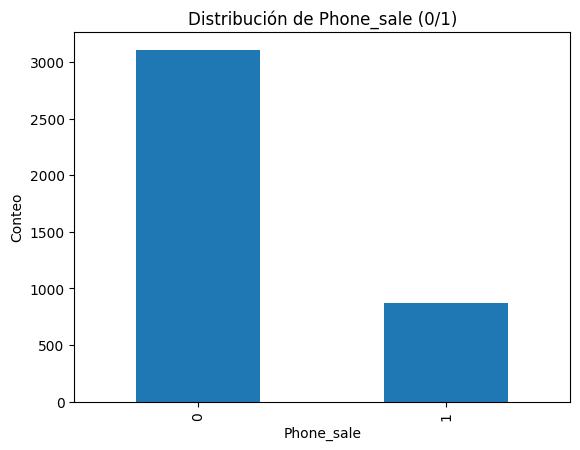

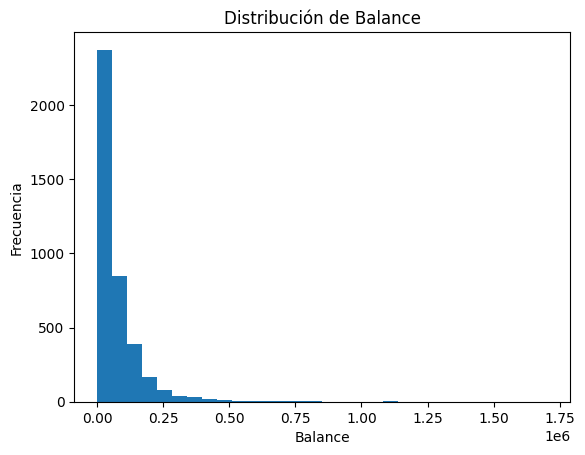

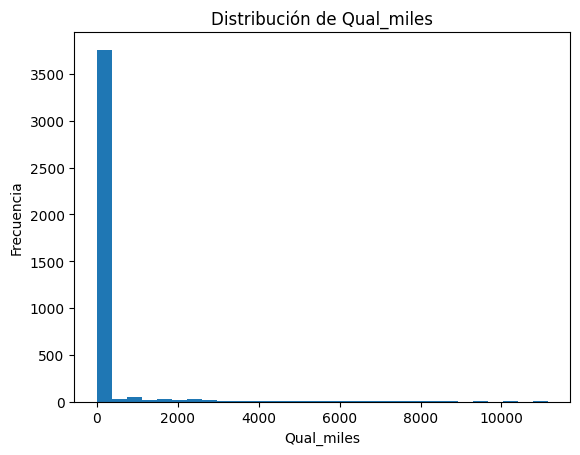

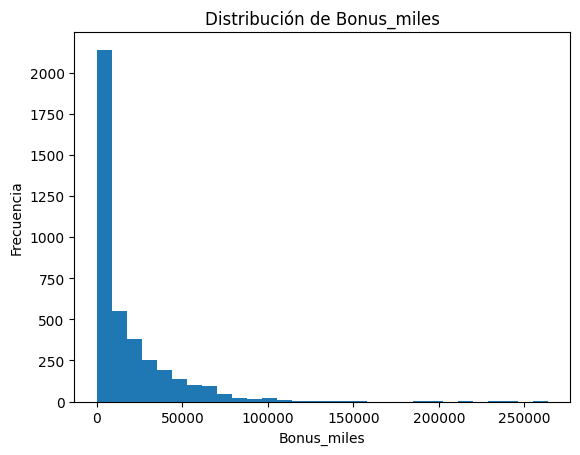

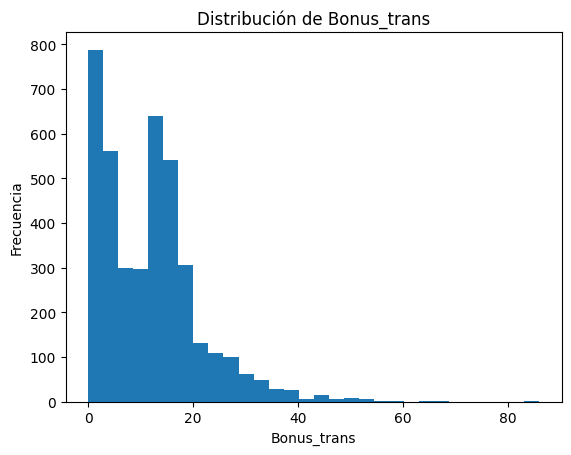

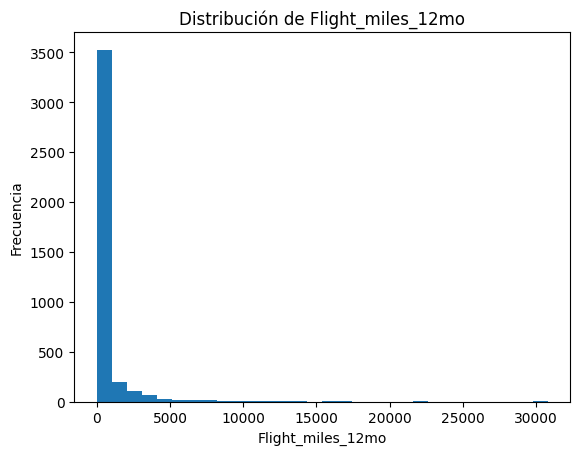

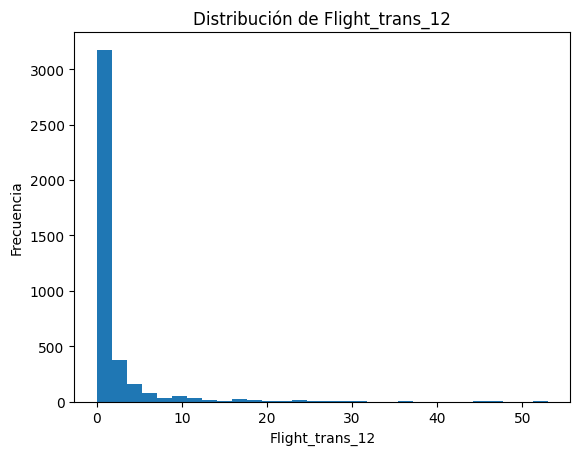

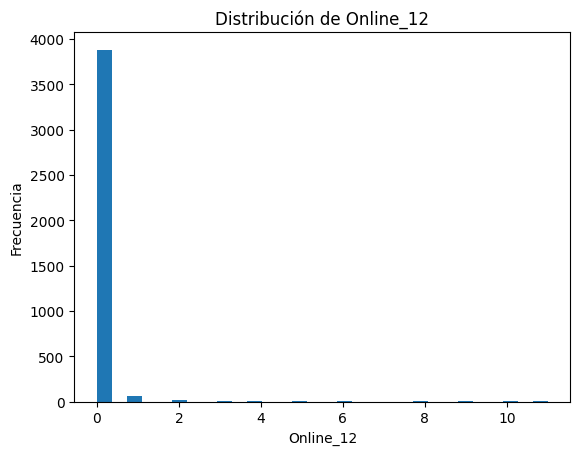

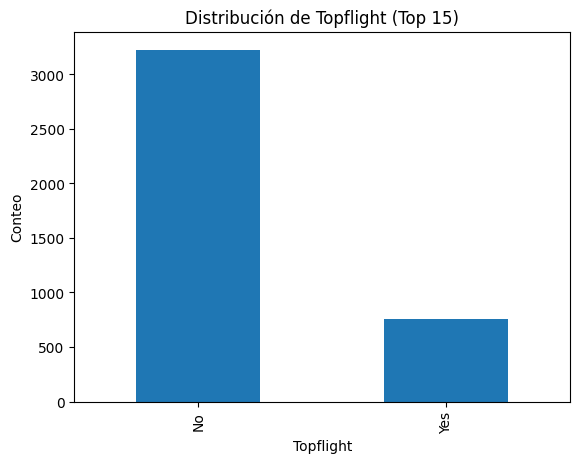

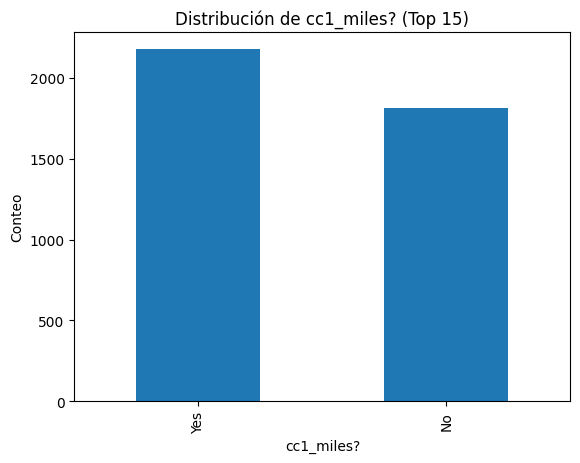

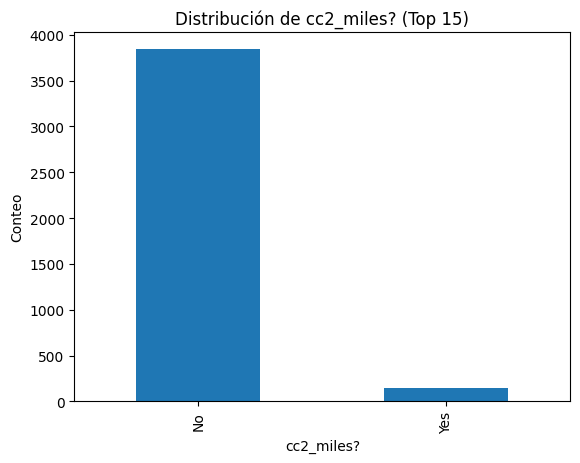

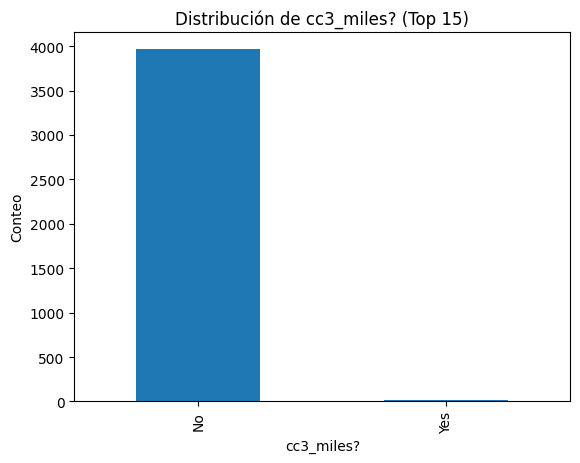

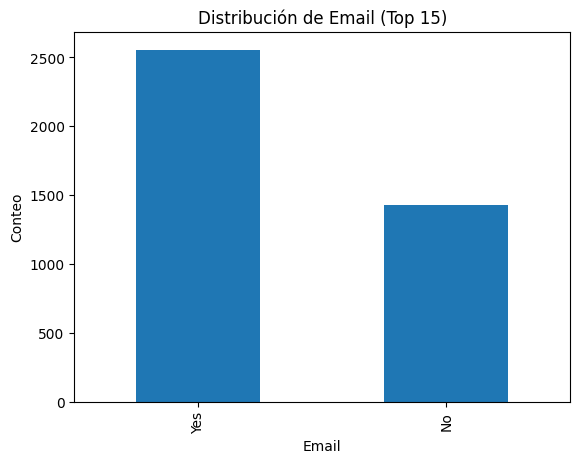

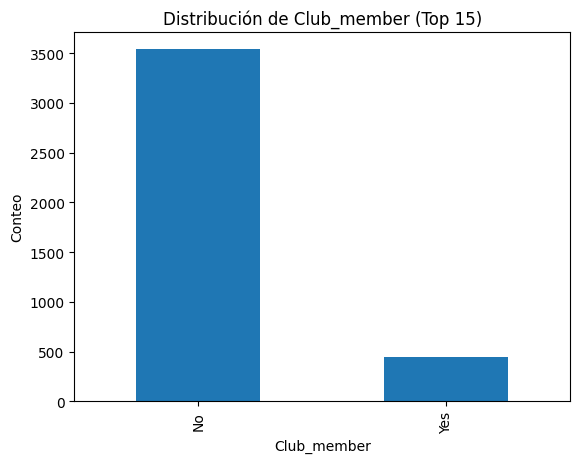

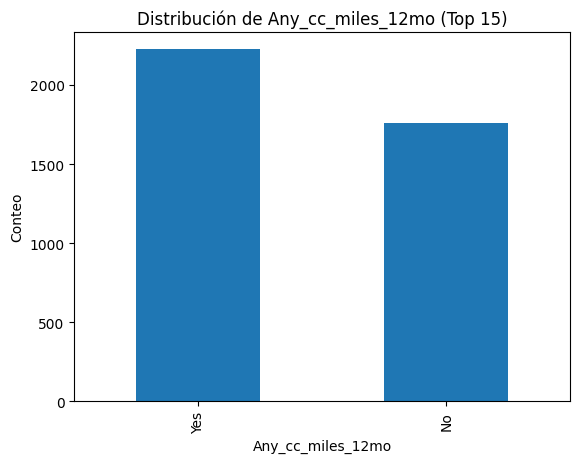

In [17]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Mostrar números completos (sin notación científica)
plt.rcParams['axes.formatter.useoffset'] = False

def x_millions(ax=None):
    ax = ax or plt.gca()
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f"{x/1e6:.2f} M"))

# Distribución de la variable objetivo
plt.figure()
df[target_col].value_counts().sort_index().plot(kind='bar')
plt.title('Distribución de Phone_sale (0/1)')
plt.xlabel('Phone_sale')
plt.ylabel('Conteo')
plt.show()

# Histogramas para variables numéricas
for c in num_cols:
    if c in df.columns:
        plt.figure(figsize=(8,6))
        df[c].plot(kind='hist', bins=30)
        plt.title(f'Distribución de {c}')
        plt.xlabel(c)
        plt.ylabel('Frecuencia')
        plt.show()
        print()

# Barras para variables categóricas (top categorías si son muchas)
for c in cat_cols:
    if c in df.columns and c != target_col:
        plt.figure(figsize=(8,6))
        df[c].value_counts().head(15).plot(kind='bar')
        plt.title(f'Distribución de {c} (Top 15)')
        plt.xlabel(c)
        plt.ylabel('Conteo')
        plt.show()
        print()

# 6) Detección de outliers (z-score + boxplots)

Posibles outliers por variable (|z| > 3):
{'Balance': 74, 'Qual_miles': 83, 'Bonus_miles': 72, 'Bonus_trans': 47, 'Flight_miles_12mo': 78, 'Flight_trans_12': 91, 'Online_12': 37}


/tmp/ipython-input-1303164039.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(df[c].dropna(), vert=True, labels=[c])


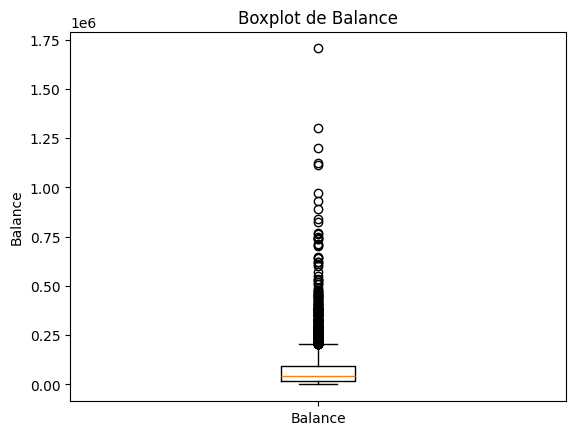

/tmp/ipython-input-1303164039.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(df[c].dropna(), vert=True, labels=[c])


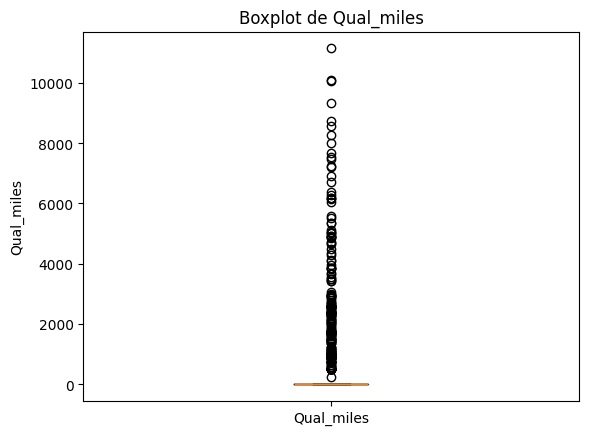

/tmp/ipython-input-1303164039.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(df[c].dropna(), vert=True, labels=[c])


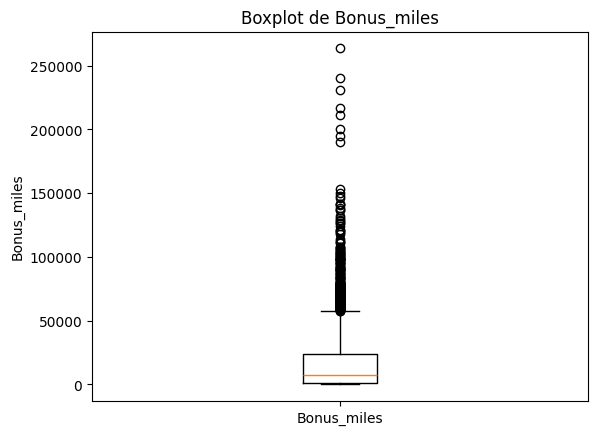

/tmp/ipython-input-1303164039.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(df[c].dropna(), vert=True, labels=[c])


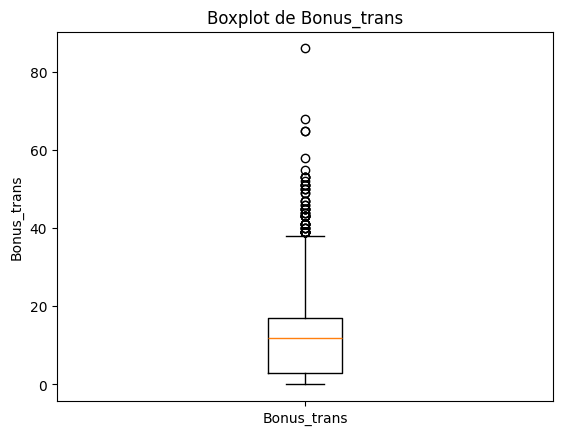

/tmp/ipython-input-1303164039.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(df[c].dropna(), vert=True, labels=[c])


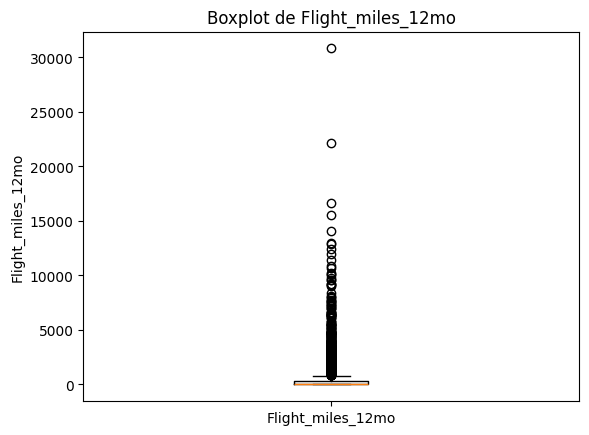

/tmp/ipython-input-1303164039.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(df[c].dropna(), vert=True, labels=[c])


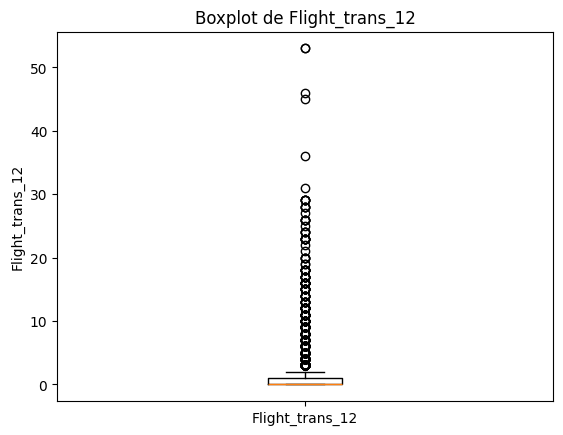

/tmp/ipython-input-1303164039.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(df[c].dropna(), vert=True, labels=[c])


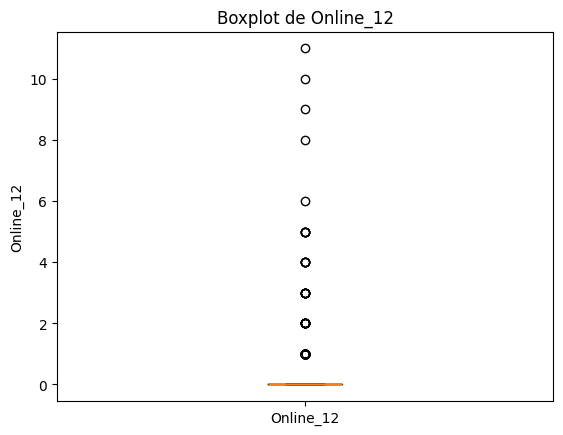

In [18]:
from scipy.stats import zscore

# Calcular z-score y reportar posibles outliers por variable numérica
outlier_report = {}
for c in num_cols:
    if c in df.columns:
        zs = zscore(df[c].astype(float))
        cnt = int((np.abs(zs) > 3).sum())
        outlier_report[c] = cnt

print("Posibles outliers por variable (|z| > 3):")
print(outlier_report)

# Boxplots por variable numérica
for c in num_cols:
    if c in df.columns:
        plt.figure(figsize=(8,6))
        plt.boxplot(df[c].dropna(), vert=True, labels=[c])
        plt.title(f'Boxplot de {c}')
        plt.ylabel(c)
        plt.show()
        print()

## 7) Análisis Multivariado

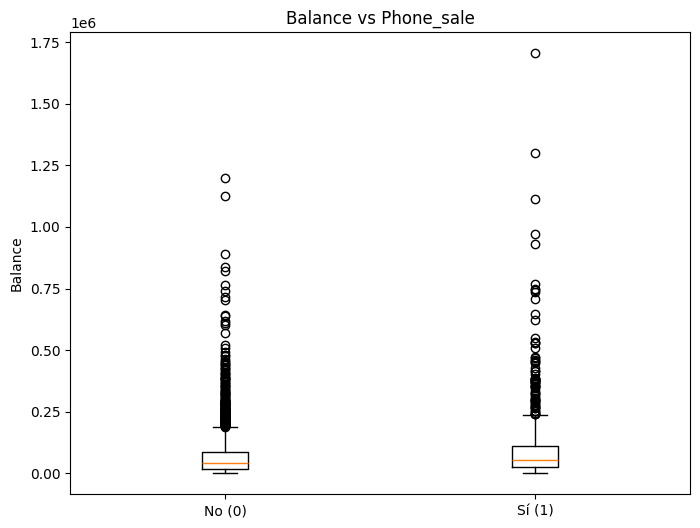

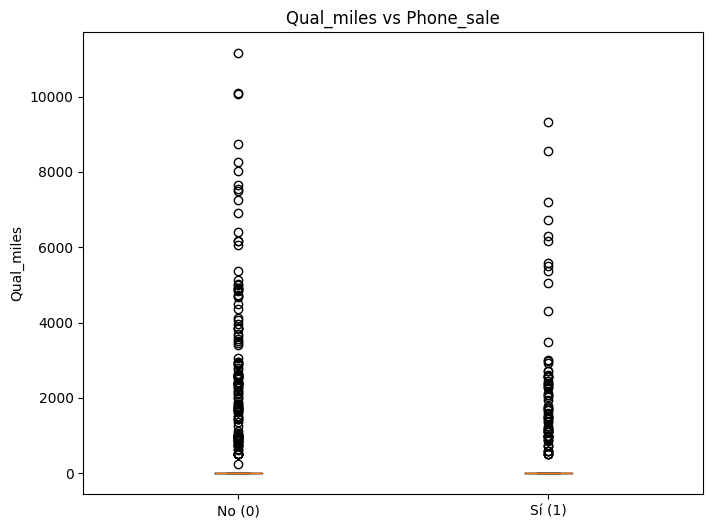

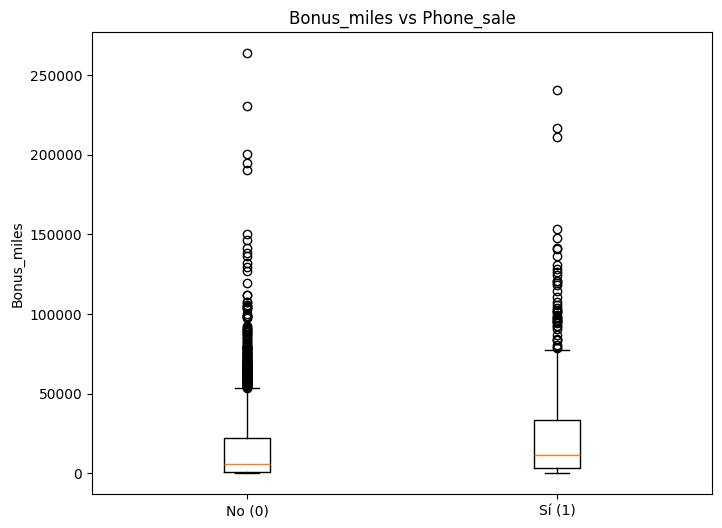

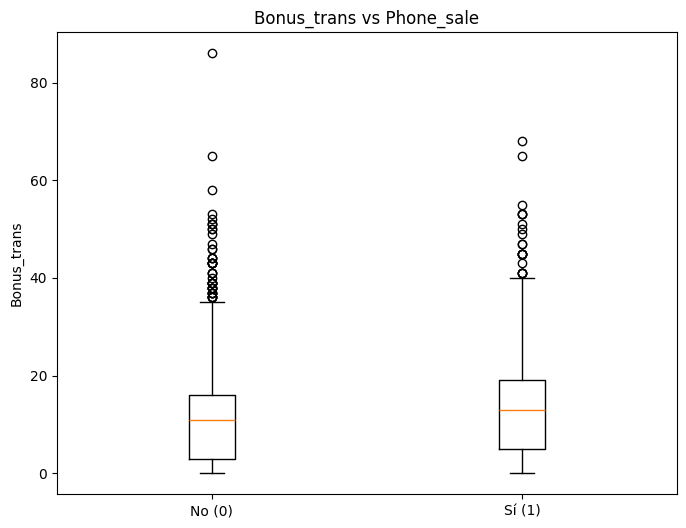

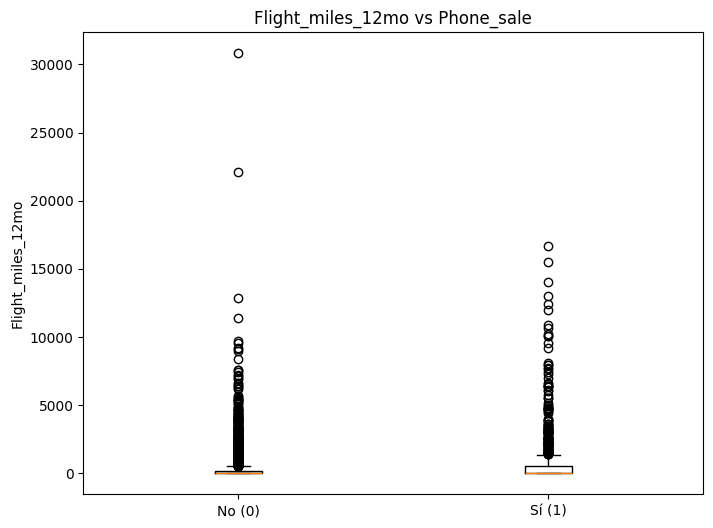

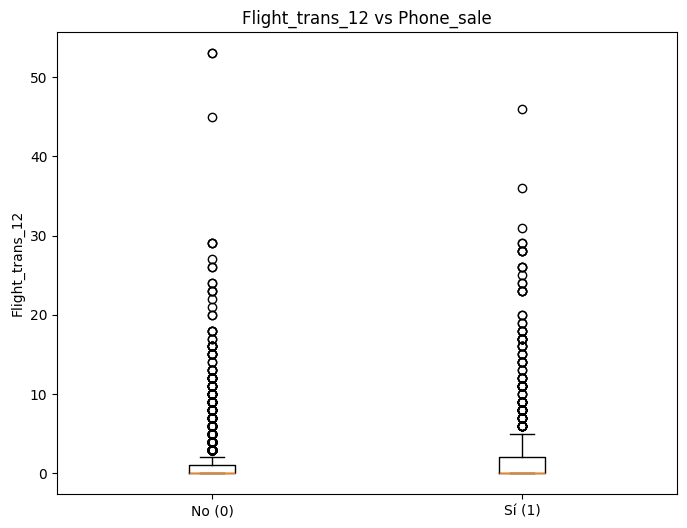

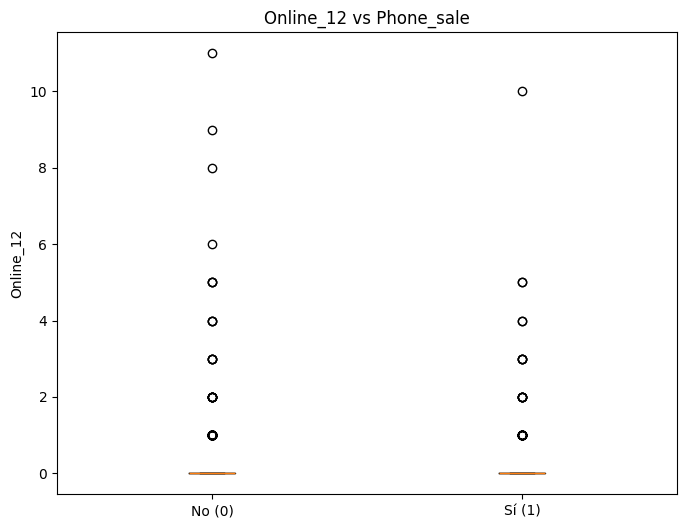

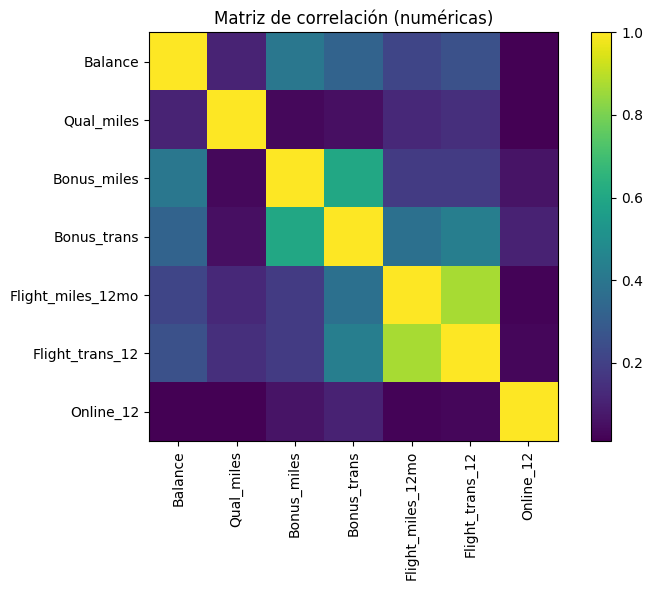

In [19]:
# Boxplot de variables numéricas vs objetivo
for c in num_cols:
    if c in df.columns and c != target_col:
        plt.figure(figsize=(8,6))
        data0 = df.loc[df[target_col]==0, c].dropna().values
        data1 = df.loc[df[target_col]==1, c].dropna().values
        plt.boxplot([data0, data1], tick_labels=['No (0)','Sí (1)'])
        plt.title(f'{c} vs Phone_sale')
        plt.ylabel(c)
        plt.show()
        print()

# Correlación entre variables numéricas
if len([c for c in num_cols_model if c in df.columns]) >= 2:
    plt.figure(figsize=(8,6))
    corr = df[num_cols_model].corr()
    # Mapa de calor
    plt.title('Matriz de correlación (numéricas)')
    plt.xticks(range(len(num_cols_model)), num_cols_model, rotation=90)
    plt.yticks(range(len(num_cols_model)), num_cols_model)
    plt.imshow(corr, interpolation='nearest')
    plt.colorbar()
    plt.tight_layout()
    plt.show()
    print()

## 8) Preparación de datos (One-Hot Encoding, split 70/30)

In [9]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=[target_col])
y = df[target_col].astype(int)

# Identificar numéricas/categóricas después de posibles drops
num_cols_model = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols_model = X.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numéricas usadas en el modelo:", num_cols_model)
print("Categóricas usadas en el modelo:", cat_cols_model)

# 70% train, 30% test, estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)
print("Tamaños:", X_train.shape, X_test.shape)

Numéricas usadas en el modelo: ['Balance', 'Qual_miles', 'Bonus_miles', 'Bonus_trans', 'Flight_miles_12mo', 'Flight_trans_12', 'Online_12']
Categóricas usadas en el modelo: ['Topflight', 'cc1_miles?', 'cc2_miles?', 'cc3_miles?', 'Email', 'Club_member', 'Any_cc_miles_12mo']
Tamaños: (2789, 14) (1196, 14)


## 9) ENTRENAMIENTO: Pipeline con balanceo (SMOTE) y modelos

In [10]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay

# SMOTE para balanceo (después del split)
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# === Winsorización por percentiles + escalado robusto ===
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

class Winsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, low=0.01, high=0.995):
        self.low = low
        self.high = high
    def fit(self, X, y=None):
        X = np.asarray(X, dtype=float)
        self.lo_ = np.percentile(X, self.low * 100, axis=0)
        self.hi_ = np.percentile(X, self.high * 100, axis=0)
        return self
    def transform(self, X):
        X = np.asarray(X, dtype=float)
        return np.clip(X, self.lo_, self.hi_)

# Transformadores
numeric_transformer = Pipeline(steps=[
    ("winsor", Winsorizer(low=0.01, high=0.995)), # para mejorar los outliers
    ("robust", RobustScaler())
])

categorical_transformer = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols_model),
        ("cat", categorical_transformer, cat_cols_model),
    ],
    remainder='drop'
)

# Modelos base
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, n_jobs=None),
    "RandomForest": RandomForestClassifier(random_state=42),
    "HistGradientBoosting": HistGradientBoostingClassifier(random_state=42)
}

results = {}

for name, model in models.items():
    pipe = ImbPipeline(steps=[
        ("preprocess", preprocess),
        ("smote", SMOTE(random_state=42)),
        ("clf", model)
    ])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:,1] if hasattr(pipe.named_steps["clf"], "predict_proba") else pipe.decision_function(X_test)

    acc = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba)
    pr  = average_precision_score(y_test, y_proba)
    cm  = confusion_matrix(y_test, y_pred)

    results[name] = {"pipeline": pipe, "acc": acc, "roc_auc": roc, "pr_auc": pr, "cm": cm}

# Mostrar resultados
for name, r in results.items():
    print(f"\n=== {name} ===")
    print("Accuracy:", round(r["acc"],4))
    print("ROC-AUC:", round(r["roc_auc"],4))
    print("PR-AUC:", round(r["pr_auc"],4))
    print("Matriz de confusión:\n", r["cm"])

# Elegir el mejor por ROC-AUC
best_name = max(results, key=lambda k: results[k]["roc_auc"])
best_pipe = results[best_name]["pipeline"]
print(f"\nMejor modelo por ROC-AUC: {best_name}")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



=== LogisticRegression ===
Accuracy: 0.8721
ROC-AUC: 0.7908
PR-AUC: 0.7027
Matriz de confusión:
 [[907  26]
 [127 136]]

=== RandomForest ===
Accuracy: 0.8503
ROC-AUC: 0.7829
PR-AUC: 0.6942
Matriz de confusión:
 [[878  55]
 [124 139]]

=== HistGradientBoosting ===
Accuracy: 0.8637
ROC-AUC: 0.7778
PR-AUC: 0.6978
Matriz de confusión:
 [[894  39]
 [124 139]]

Mejor modelo por ROC-AUC: LogisticRegression


In [12]:
for name, r in results.items():
    print("\nModelo:", name)
    print("Claves disponibles:", r.keys())


Modelo: LogisticRegression
Claves disponibles: dict_keys(['pipeline', 'acc', 'roc_auc', 'pr_auc', 'cm'])

Modelo: RandomForest
Claves disponibles: dict_keys(['pipeline', 'acc', 'roc_auc', 'pr_auc', 'cm'])

Modelo: HistGradientBoosting
Claves disponibles: dict_keys(['pipeline', 'acc', 'roc_auc', 'pr_auc', 'cm'])


# 10) Guardar Modelo

In [13]:
import joblib

best_name = max(results, key=lambda k: results[k]['roc_auc'])
best_pipe = results[best_name]['pipeline']

joblib.dump(best_pipe, '/content/best_model.pkl')

best_name

'LogisticRegression'

## 11) Curvas ROC — Comparación Train vs Test

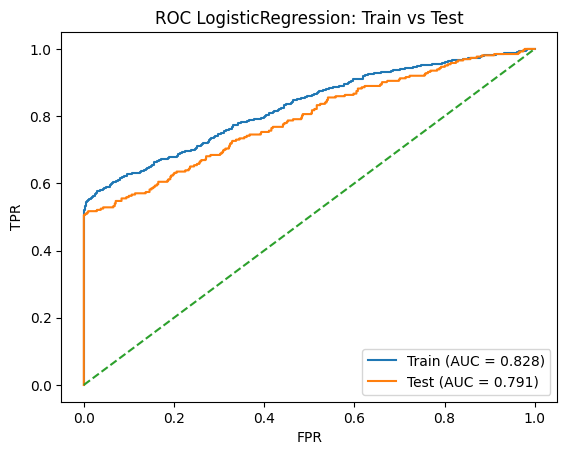

In [14]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curves(pipeline, X_tr, y_tr, X_te, y_te, title="Curva ROC"):
    # Predicciones probabilísticas
    if hasattr(pipeline.named_steps["clf"], "predict_proba"):
        y_tr_scores = pipeline.predict_proba(X_tr)[:,1]
        y_te_scores = pipeline.predict_proba(X_te)[:,1]
    else:
        y_tr_scores = pipeline.decision_function(X_tr)
        y_te_scores = pipeline.decision_function(X_te)

    fpr_tr, tpr_tr, _ = roc_curve(y_tr, y_tr_scores)
    fpr_te, tpr_te, _ = roc_curve(y_te, y_te_scores)

    roc_auc_tr = auc(fpr_tr, tpr_tr)
    roc_auc_te = auc(fpr_te, tpr_te)

    plt.figure()
    plt.plot(fpr_tr, tpr_tr, label=f'Train (AUC = {roc_auc_tr:.3f})')
    plt.plot(fpr_te, tpr_te, label=f'Test (AUC = {roc_auc_te:.3f})')
    plt.plot([0,1],[0,1],'--')
    plt.title(title)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend(loc='lower right')
    plt.show()

plot_roc_curves(best_pipe, X_train, y_train, X_test, y_test, title=f'ROC {best_name}: Train vs Test')

## 12) Optimización de hiperparámetros

In [15]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

search_spaces = {}

# Espacios de búsqueda para algunos modelos
search_spaces["RandomForest"] = {
    "clf__n_estimators": randint(100, 400),
    "clf__max_depth": randint(3, 20),
    "clf__min_samples_split": randint(2, 20),
    "clf__min_samples_leaf": randint(1, 10),
    "clf__max_features": ["sqrt", "log2", None]
}
search_spaces["LogisticRegression"] = {
    "clf__C": uniform(0.01, 10),
    "clf__penalty": ["l2"],
    "clf__solver": ["lbfgs", "liblinear"]
}
search_spaces["HistGradientBoosting"] = {
    "clf__max_depth": randint(3, 20),
    "clf__learning_rate": uniform(0.01, 0.3),
    "clf__l2_regularization": uniform(0.0, 0.5),
    "clf__max_leaf_nodes": randint(15, 63)
}

# Solo optimizamos el mejor modelo detectado
param_dist = search_spaces.get(best_name, None)

if param_dist is not None:
    opt = RandomizedSearchCV(
        estimator=best_pipe,
        param_distributions=param_dist,
        n_iter=25,
        scoring="roc_auc",
        n_jobs=-1,
        cv=5,
        random_state=42,
        verbose=1
    )
    opt.fit(X_train, y_train)
    print("\nMejores hiperparámetros:", opt.best_params_)
    print("Mejor ROC-AUC (CV):", round(opt.best_score_, 4))

    # Evaluar en test
    best_model = opt.best_estimator_
else:
    print("No hay espacio de búsqueda definido para", best_name, "- se usa el pipeline por defecto.")
    best_model = best_pipe

# Métricas finales
if hasattr(best_model.named_steps["clf"], "predict_proba"):
    y_proba = best_model.predict_proba(X_test)[:,1]
else:
    y_proba = best_model.decision_function(X_test)

y_pred = best_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_proba)
pr  = average_precision_score(y_test, y_proba)
cm  = confusion_matrix(y_test, y_pred)

print("\n=== MÉTRICAS FINALES EN TEST ===")
print("Accuracy:", round(acc,4))
print("ROC-AUC:", round(roc,4))
print("PR-AUC:", round(pr,4))
print("Matriz de confusión:\n", cm)

Fitting 5 folds for each of 25 candidates, totalling 125 fits

Mejores hiperparámetros: {'clf__C': np.float64(0.017787658410143285), 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Mejor ROC-AUC (CV): 0.8198

=== MÉTRICAS FINALES EN TEST ===
Accuracy: 0.8696
ROC-AUC: 0.7855
PR-AUC: 0.6984
Matriz de confusión:
 [[903  30]
 [126 137]]


## 13) VALIDACION

In [16]:
import joblib
import pandas as pd

# 13.0 Cargar Modelo
MODELO_PATH = "/content/best_model.pkl"
with open(MODELO_PATH, "rb") as f:
    modelo_cargado = joblib.load(f)
print("Modelo cargado correctamente desde:", MODELO_PATH)

# 13.1 Cargar nuevo dataset (CSV)
NUEVO_DATASET_PATH = "/content/data_nueva.csv"

try:
    df_nuevo = pd.read_csv(NUEVO_DATASET_PATH)
    print("Dimensión del nuevo dataset:", df_nuevo.shape)
    display(df_nuevo.head())

    # 13.2 Predicción
    probabilidades = modelo_cargado.predict_proba(df_nuevo)[:,1]
    predicciones = modelo_cargado.predict(df_nuevo)

    df_resultado = df_nuevo.copy()
    df_resultado["prob_predicha"] = probabilidades
    df_resultado["prediccion"] = predicciones

    display(df_resultado.head())

    # 13.3 Exportar CSV
    CSV_SALIDA = "/content/prediccion.csv"
    df_resultado.to_csv(CSV_SALIDA, index=False, encoding="utf-8")
    print("Archivo generado correctamente en:", CSV_SALIDA)

except FileNotFoundError:
    print(f"Error: El archivo '{NUEVO_DATASET_PATH}' no fue encontrado. Verifica la ruta o sube el archivo.")
except Exception as e:
    print(f"Ocurrió un error durante la predicción: {e}")

Modelo cargado correctamente desde: /content/best_model.pkl
Dimensión del nuevo dataset: (1000, 16)


,ID#,Topflight,Balance,Qual_miles,cc1_miles?,cc2_miles?,cc3_miles?,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Online_12,Email,Club_member,Any_cc_miles_12mo,Phone_sale
0,4008,No,59017,0,Yes,No,No,34746,25,0,0,1,Yes,No,Yes,No
1,4009,No,34235,0,Yes,No,No,18910,7,250,1,0,Yes,No,Yes,No
2,4010,No,11933,0,No,No,No,249,3,79,1,0,Yes,No,No,No
3,4011,No,5000,0,No,No,No,2125,3,0,0,0,Yes,No,No,Yes
4,4012,No,2622,0,No,No,No,1625,6,0,0,0,No,Yes,No,Yes


,ID#,Topflight,Balance,Qual_miles,cc1_miles?,cc2_miles?,cc3_miles?,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Online_12,Email,Club_member,Any_cc_miles_12mo,Phone_sale,prob_predicha,prediccion
0,4008,No,59017,0,Yes,No,No,34746,25,0,0,1,Yes,No,Yes,No,0.543177,1
1,4009,No,34235,0,Yes,No,No,18910,7,250,1,0,Yes,No,Yes,No,0.365468,0
2,4010,No,11933,0,No,No,No,249,3,79,1,0,Yes,No,No,No,0.238423,0
3,4011,No,5000,0,No,No,No,2125,3,0,0,0,Yes,No,No,Yes,0.243682,0
4,4012,No,2622,0,No,No,No,1625,6,0,0,0,No,Yes,No,Yes,0.999468,1


Archivo generado correctamente en: /content/prediccion.csv
